# 开始使用

本节介绍 reki 库的主要功能。

首先导入需要使用的一些库。

In [2]:
import datetime

import numpy as np
import pandas as pd
import xarray as xr
import eccodes

生成起报时次和预报时效。

In [6]:
start_time = pd.Timestamp.utcnow().floor(freq="D") - pd.Timedelta(days=2)
start_time_label = start_time.strftime("%Y%m%d%H")
forecast_time_label = "24h"
forecast_time = pd.to_timedelta(forecast_time_label)
print("start_time:", start_time)
print("start_time_label:", start_time_label)
print("forecast_time:", forecast_time)
print("forecast_time_label:", forecast_time_label)

start_time: 2025-07-01 00:00:00+00:00
start_time_label: 2025070100
forecast_time: 1 days 00:00:00
forecast_time_label: 24h


## 本地文件查找

reki 内置了 CMA 国家级气象超算子系统 1 (CMA-HPC2023-SC1) 共享文件系统 (/g3/COMMONDATA) 中业务系统产品文件路径。

下面示例获取 CMA-GFS 系统原始分辨率 GRIB2 文件路径。

In [4]:
from reki.data_finder import find_local_file

gfs_grib2_file_path = find_local_file(
    "cma_gfs_gmf/grib2/orig",
    start_time=start_time,
    forecast_time=forecast_time,
)
gfs_grib2_file_path

PosixPath('/g3/COMMONDATA/OPER/CEMC/GFS_GMF/Prod-grib/2025070100/ORIG/gmf.gra.2025070100024.grb2')

`find_local_file` 函数支持一些参数来定义更精确的文件查找条件。
比如 `number` 参数表示集合预报成员编号。

下面示例获取 CMA-GEPS 系统第 2 个集合成员 024 时效的原始分辨率 GRIB2 文件路径。

In [7]:
geps_grib2_file_path = find_local_file(
    "cma_geps/grib2/orig",
    start_time=start_time_label,
    forecast_time=forecast_time_label,
    number=2,
)
geps_grib2_file_path

PosixPath('/g3/COMMONDATA/OPER/CEMC/GEPS/Prod-grib/2025070100/grib2/gef.gra.002.2025070100024.grb2')

reki 也内置了模式输出的一些中间文件。

下面示例获取 CMA-GFS 系统 240 时效的模式面二进制数据文件路径。

In [10]:
gfs_modelvar_file_path = find_local_file(
    "cma_gfs_gmf/bin/modelvar",
    start_time=start_time,
    forecast_time="240h",
)
gfs_modelvar_file_path

PosixPath('/g3/COMMONDATA/OPER/CEMC/GFS_GMF/Fcst-long/2025070100/modelvar2025070100_240')

reki 内置的配置文件请查看 `reki/data_finder/conf` 目录。

## 读取 GRIB2 文件

### 基本方法

reki 使用 eccodes 从 GRIB2 文件中检索要素场，并返回 `xarray.DataArray` 对象。

下面示例从 CMA-GFS 的 GRIB2 产品文件中加载 850hPa 温度场。其中：

- `parameter` 参数表示要素名称，`t` 代表温度
- `level_type` 参数表示层次类型，`pl` 代表等压面层，单位 hPa
- `level` 参数表示层次值

In [11]:
from reki.format.grib.eccodes import load_field_from_file

field = load_field_from_file(
    gfs_grib2_file_path,
    parameter="t",
    level_type="pl",
    level=850,
)
field

<xarray.DataArray 't' (latitude: 1440, longitude: 2880)> Size: 33MB
array([[276.25300781, 276.25300781, 276.25300781, ..., 276.25300781,
        276.25300781, 276.25300781],
       [276.04300781, 276.05300781, 276.05300781, ..., 276.04300781,
        276.04300781, 276.04300781],
       [275.88300781, 275.88300781, 275.88300781, ..., 275.88300781,
        275.88300781, 275.88300781],
       ...,
       [228.00300781, 228.18300781, 228.36300781, ..., 227.94300781,
        227.91300781, 227.91300781],
       [228.17300781, 228.17300781, 228.18300781, ..., 228.20300781,
        228.20300781, 228.19300781],
       [228.27300781, 228.27300781, 228.28300781, ..., 228.27300781,
        228.27300781, 228.27300781]], shape=(1440, 2880))
Coordinates:
    time        datetime64[ns] 8B 2025-07-01
    step        timedelta64[ns] 8B 1 days
    valid_time  datetime64[ns] 8B 2025-07-02
    pl          float64 8B 850.0
  * latitude    (latitude) float64 12kB 89.94 89.81 89.69 ... -89.81 -89.94
  * longitude   (longitude) float64 23kB 0.0 0.125 0.25 ... 359.6 359.8 359.9
Attributes: (12/17)
    GRIB_edition:             2
    GRIB_centre:              babj
    GRIB_subCentre:           0
    GRIB_tablesVersion:       4
    GRIB_localTablesVersion:  0
    GRIB_dataType:            fc
    ...                       ...
    GRIB_stepType:            instant
    GRIB_stepUnits:           1
    GRIB_stepRange:           24
    GRIB_endStep:int:         24
    GRIB_count:               109
    long_name:                discipline=0 parmcat=0 parm=0

可以使用 xarray 提供的一系列功能对要素场进行分析。比如使用 `xarray.DataArray.plot()` 函数实现快速绘图。

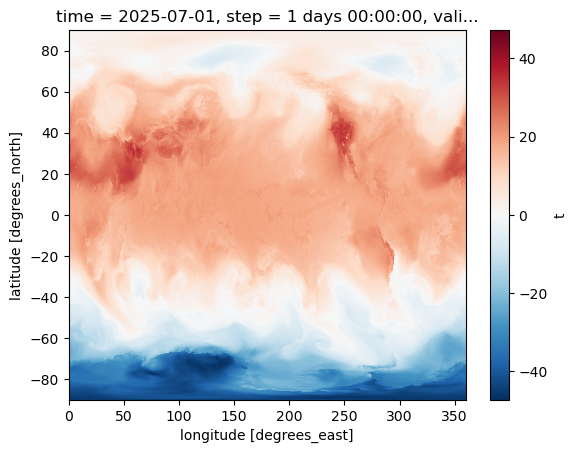

In [12]:
(field - 273.15).plot()

### 层次类型

reki 支持从模式面数据中加载要素场。

下面代码从 CMA-GFS 的模式面 GRIB2 数据中加载第 10 层 u 分量，其中 `ml` 表示模式面。

In [13]:
gfs_model_grib2_file_path = find_local_file(
    "cma_gfs_gmf/grib2/modelvar",
    start_time=start_time,
    forecast_time=forecast_time,
)
gfs_model_grib2_file_path

PosixPath('/g3/COMMONDATA/OPER/CEMC/GFS_GMF/Prod-grib/2025070100/MODELVAR/modelvar2025070100024.grb2')

In [14]:
field = load_field_from_file(
    gfs_model_grib2_file_path,
    parameter="u",
    level_type="ml",
    level=10,
)
field

<xarray.DataArray 'u' (latitude: 1440, longitude: 2880)> Size: 33MB
array([[5.16223877, 5.17223877, 5.18223877, ..., 5.12223877, 5.13223877,
        5.15223877],
       [4.02223877, 4.03223877, 4.04223877, ..., 3.99223877, 4.00223877,
        4.01223877],
       [3.73223877, 3.74223877, 3.75223877, ..., 3.69223877, 3.70223877,
        3.71223877],
       ...,
       [0.26223877, 0.27223877, 0.29223877, ..., 0.20223877, 0.22223877,
        0.24223877],
       [0.46223877, 0.48223877, 0.50223877, ..., 0.40223877, 0.42223877,
        0.44223877],
       [0.42223877, 0.45223877, 0.47223877, ..., 0.34223877, 0.37223877,
        0.40223877]], shape=(1440, 2880))
Coordinates:
    time        datetime64[ns] 8B 2025-07-01
    step        timedelta64[ns] 8B 1 days
    valid_time  datetime64[ns] 8B 2025-07-02
    ml          int64 8B 10
  * latitude    (latitude) float64 12kB 89.94 89.81 89.69 ... -89.81 -89.94
  * longitude   (longitude) float64 23kB 0.0 0.125 0.25 ... 359.6 359.8 359.9
Attributes: (12/17)
    GRIB_edition:             2
    GRIB_centre:              babj
    GRIB_subCentre:           0
    GRIB_tablesVersion:       4
    GRIB_localTablesVersion:  0
    GRIB_dataType:            fc
    ...                       ...
    GRIB_stepType:            instant
    GRIB_stepUnits:           1
    GRIB_stepRange:           24
    GRIB_endStep:int:         24
    GRIB_count:               187
    long_name:                discipline=0 parmcat=2 parm=2

### 更多筛选条件

`load_field_from_file` 函数的部分参数支持使用 ecCodes 的 GRIB Key 作为值，支持的参数包括：

- parameter
- level_type
- level

同时也支持将 GRIB Key 直接作为参数传递。

下面代码通过字典形式的 `parameter` 参数加载 850hPa 雷达反射率场。

In [15]:
field = load_field_from_file(
    gfs_grib2_file_path,
    parameter={
        "discipline": 0,
        "parameterCategory": 16,
        "parameterNumber": 225,
    },
    level_type="pl",
    level=850
)
field

<xarray.DataArray '0_16_225' (latitude: 1440, longitude: 2880)> Size: 33MB
array([[-30., -30., -30., ..., -30., -30., -30.],
       [-30., -30., -30., ..., -30., -30., -30.],
       [-30., -30., -30., ..., -30., -30., -30.],
       ...,
       [-30., -30., -30., ..., -30., -30., -30.],
       [-30., -30., -30., ..., -30., -30., -30.],
       [-30., -30., -30., ..., -30., -30., -30.]], shape=(1440, 2880))
Coordinates:
    time        datetime64[ns] 8B 2025-07-01
    step        timedelta64[ns] 8B 1 days
    valid_time  datetime64[ns] 8B 2025-07-02
    pl          float64 8B 850.0
  * latitude    (latitude) float64 12kB 89.94 89.81 89.69 ... -89.81 -89.94
  * longitude   (longitude) float64 23kB 0.0 0.125 0.25 ... 359.6 359.8 359.9
Attributes: (12/17)
    GRIB_edition:             2
    GRIB_centre:              babj
    GRIB_subCentre:           0
    GRIB_tablesVersion:       4
    GRIB_localTablesVersion:  1
    GRIB_dataType:            fc
    ...                       ...
    GRIB_stepType:            instant
    GRIB_stepUnits:           1
    GRIB_stepRange:           24
    GRIB_endStep:int:         24
    GRIB_count:               790
    long_name:                discipline=0 parmcat=16 parm=225

### ecCodes 接口

reki 支持返回 ecCode Python API 的 GRIB message。

下面代码加载 850hPa 位势高度场。首先获取 GRIB message。

In [16]:
from reki.format.grib.eccodes import load_message_from_file

message = load_message_from_file(
    gfs_grib2_file_path,
    parameter="gh",
    level_type="pl",
    level=850
)
message

94413045163616

读取经纬度格点数和数据值，将数据重组成二维数组。

In [17]:
values = eccodes.codes_get_double_array(message, "values")
ni = eccodes.codes_get_long(message, "Ni")
nj = eccodes.codes_get_long(message, "Nj")
values.reshape(nj, ni)

array([[1386.66015625, 1386.66015625, 1386.66015625, ..., 1386.66015625,
        1386.66015625, 1386.66015625],
       [1387.16015625, 1387.16015625, 1387.16015625, ..., 1387.16015625,
        1387.16015625, 1387.16015625],
       [1387.66015625, 1387.66015625, 1387.66015625, ..., 1387.66015625,
        1387.66015625, 1387.66015625],
       ...,
       [1262.66015625, 1261.46015625, 1260.26015625, ..., 1263.06015625,
        1263.26015625, 1263.26015625],
       [1263.16015625, 1263.16015625, 1263.06015625, ..., 1262.96015625,
        1262.96015625, 1263.06015625],
       [1263.76015625, 1263.76015625, 1263.76015625, ..., 1263.76015625,
        1263.76015625, 1263.76015625]], shape=(1440, 2880))

释放 GRIB 消息对象

In [18]:
eccodes.codes_release(message)